In [48]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

In [49]:
MODEL = "ddm"
RUN_SIMS = False
DEVICE = "cpu"

In [50]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/"

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [46]:
model_config

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x11aa37100>}

In [47]:
generator_config["output_folder"] = (
    "data/lan_mlp/"
    + generator_config["dgp_list"]
    + "/"
    + str(generator_config["n_samples"])
    + "_"
    + str(generator_config["n_training_samples_by_parameter_set"])
    + "/"
)

KeyError: 'dgp_list'

In [ ]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print("Datafile: ", i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        training_data = my_dataset_generator.generate_data_training_uniform(save=True)

In [51]:
import pickle

folder_ = "../data/lan_mlp/" + MODEL + "/"
files_ = [folder_ + file_ for file_ in os.listdir(folder_)]

my_data = pickle.load(
    open(
        files_[0],
        "rb",
    )
)

In [52]:
network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [53]:
network_config["train_output_type"] = "logits"


train_config["loss"] = "bcelogit"
train_config["cpu_batch_size"] = 1024
train_config["gpu_batch_size"] = 1024
train_config["n_epochs"] = 10

In [54]:
folder_ = "../data/lan_mlp/" + MODEL + "/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="cpn_data",
    label_key="cpn_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="cpn_data",
    label_key="cpn_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

In [55]:
cnt = 0
for xb, yb in jax_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 10:
        break

tensor([[ 0.0230,  0.8928,  0.2771,  1.8274],
        [ 0.0773,  1.1757,  0.1404,  0.9382],
        [-0.8907,  2.2692,  0.7324,  1.0069],
        ...,
        [-1.3451,  1.1634,  0.6648,  1.9732],
        [ 2.5755,  0.7371,  0.6242,  0.0403],
        [-1.3828,  1.4075,  0.5868,  1.0250]])
tensor([[0.7155],
        [0.8210],
        [0.8890],
        ...,
        [0.8740],
        [0.0070],
        [0.9635]])
tensor([[-2.1197,  1.4374,  0.8743,  1.9186],
        [-1.6401,  2.4682,  0.8981,  0.8245],
        [-2.2833,  0.9635,  0.2890,  1.5146],
        ...,
        [-2.2025,  0.7549,  0.2196,  0.9994],
        [-2.9090,  1.2080,  0.8279,  0.4686],
        [-1.4978,  0.4554,  0.1142,  1.9158]])
tensor([[0.8000],
        [0.8315],
        [0.9985],
        ...,
        [0.9965],
        [0.9270],
        [0.9765]])
tensor([[ 0.4716,  0.4065,  0.7690,  1.8287],
        [ 0.8742,  0.9753,  0.1557,  0.0602],
        [-1.0113,  0.6423,  0.4338,  1.5325],
        ...,
        [-0.7304,  0.6087

In [57]:
# LOAD NETWORK
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)
pickle.dump(
    network_config,
    open(
        "../data/jax_models/" + MODEL + "/" + MODEL + "_jax_cpn_network_config.pickle",
        "wb",
    ),
)

In [58]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [59]:
train_state = jax_trainer.train_and_evaluate(
    output_folder="../data/jax_models/" + MODEL + "/",
    output_file_id=MODEL,
    run_id="test_cpn",
    wandb_on=False,
    wandb_project_id="test_cpn",
    save_data_details=True,
    verbose=1,
    save_all=True,
)

Found folder:  ..
Moving on...
Found folder:  ../data
Moving on...
Found folder:  ../data/jax_models
Moving on...
Found folder:  ../data/jax_models/ddm
Moving on...
Epoch: 0 of 10
Training - Step: 0 of 225 - Loss: 0.60183203
Epoch 0/10 time: 10.109797954559326s
Validation - Step: 0 of 225 - Loss: 0.3189134
Epoch 0/10 time: 8.907364130020142s
Epoch: 0 / 10, test_loss: 0.32131388783454895
Epoch: 1 of 10
Training - Step: 0 of 225 - Loss: 0.33258647
Epoch 1/10 time: 9.075368881225586s
Validation - Step: 0 of 225 - Loss: 0.31904417
Epoch 1/10 time: 9.757975101470947s
Epoch: 1 / 10, test_loss: 0.3192121684551239
Epoch: 2 of 10
Training - Step: 0 of 225 - Loss: 0.30525112
Epoch 2/10 time: 8.732094049453735s
Validation - Step: 0 of 225 - Loss: 0.3184372
Epoch 2/10 time: 8.733233213424683s
Epoch: 2 / 10, test_loss: 0.32003405690193176
Epoch: 3 of 10
Training - Step: 0 of 225 - Loss: 0.31566334
Epoch 3/10 time: 8.568460702896118s
Validation - Step: 0 of 225 - Loss: 0.3370237
Epoch 3/10 time: 8.8

In [ ]:
print(network_config)

{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}


In [60]:
# Loaded Net
jax_infer = lanfactory.trainers.MLPJaxFactory(
    network_config=network_config,
    train=False,
)

In [62]:
my_state = jax_infer.load_state_from_file(
    file_path="../data/jax_models/" + MODEL + "/test_cpn_cpn_ddm__train_state.jax"
)

passing through transform


In [65]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="../data/jax_models/" + MODEL + "/test_cpn_cpn_ddm__train_state.jax",
    add_jitted=True,
)

passing through transform


In [78]:
import jax.numpy as jnp
import numpy as np

# Test parameters:
v, a, z, t = 0.5, 1.5, 0.5, 0.3
v = np.linspace(-3, 3, 50)

# Comparison simulator run
choice_p_list = []
for v_tmp in v:
    print(v_tmp)
    sim_out = ssms.basic_simulators.simulator.simulator(
        model=MODEL, theta=[v_tmp, a, z, t], n_samples=2000
    )
    choice_p_list.append(
        np.sum(sim_out["choices"] == -1.0) / sim_out["choices"].shape[0]
    )

# Make input matric
input_mat = jnp.zeros((50, 4))
input_mat = input_mat.at[:, 0].set(jnp.array(v))
input_mat = input_mat.at[:, 1].set(jnp.ones(50) * a)
input_mat = input_mat.at[:, 2].set(jnp.ones(50) * z)
input_mat = input_mat.at[:, 3].set(jnp.ones(50) * t)

net_out = forward_pass_jitted(input_mat)

-3.0
-2.877551020408163
-2.7551020408163267
-2.63265306122449
-2.510204081632653
-2.387755102040816
-2.2653061224489797
-2.142857142857143
-2.020408163265306
-1.8979591836734695
-1.7755102040816326
-1.653061224489796
-1.5306122448979593
-1.4081632653061225
-1.2857142857142858
-1.163265306122449
-1.0408163265306123
-0.9183673469387754
-0.795918367346939
-0.6734693877551021
-0.5510204081632653
-0.4285714285714288
-0.30612244897959195
-0.18367346938775508
-0.06122448979591866
0.06122448979591821
0.18367346938775508
0.30612244897959195
0.4285714285714284
0.5510204081632653
0.6734693877551021
0.7959183673469385
0.9183673469387754
1.0408163265306118
1.1632653061224492
1.2857142857142856
1.408163265306122
1.5306122448979593
1.6530612244897958
1.7755102040816322
1.8979591836734695
2.020408163265306
2.1428571428571423
2.2653061224489797
2.387755102040816
2.5102040816326525
2.63265306122449
2.7551020408163263
2.8775510204081627
3.0


In [83]:
sim_out["choice_p"]

array([[5.000e-04, 9.995e-01]])

Text(0.5, 0, 'v')

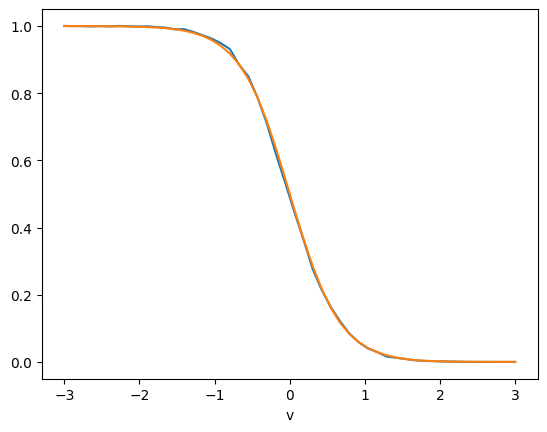

In [82]:
from matplotlib import pyplot as plt

plt.plot(input_mat.at[:, 0].set(jnp.array(v))[:, 0], choice_p_list)
plt.plot(input_mat.at[:, 0].set(jnp.array(v))[:, 0], np.exp(net_out))
plt.xlabel("v")

In [72]:
np.exp(net_out)

array([[9.9949121e-01],
       [9.9944276e-01],
       [9.9937797e-01],
       [9.9928951e-01],
       [9.9916565e-01],
       [9.9898762e-01],
       [9.9872535e-01],
       [9.9833125e-01],
       [9.9773163e-01],
       [9.9681586e-01],
       [9.9542737e-01],
       [9.9335217e-01],
       [9.9030405e-01],
       [9.8589939e-01],
       [9.7961831e-01],
       [9.7075099e-01],
       [9.5833552e-01],
       [9.4110185e-01],
       [9.1743165e-01],
       [8.8535011e-01],
       [8.4261829e-01],
       [7.8712934e-01],
       [7.1787149e-01],
       [6.3623816e-01],
       [5.4648054e-01],
       [4.5447949e-01],
       [3.6594564e-01],
       [2.8543937e-01],
       [2.1616854e-01],
       [1.5976143e-01],
       [1.1601422e-01],
       [8.3285108e-02],
       [5.9331749e-02],
       [4.1968789e-02],
       [2.9401984e-02],
       [2.0324167e-02],
       [1.3843405e-02],
       [9.3300734e-03],
       [6.2859668e-03],
       [4.2913300e-03],
       [3.0071924e-03],
       [2.183395